In [ ]:
!pip install ultralytics
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
from ultralytics import YOLO
import numpy as np
import base64
import io
from PIL import Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
yolo = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 90.4MB/s]


<IPython.core.display.Javascript object>

requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 3.5s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


0: 480x640 4 persons, 5 chairs, 1 laptop, 72.7ms
Speed: 13.7ms preprocess, 72.7ms inference, 721.9ms postprocess per image at shape (1, 3, 480, 640)


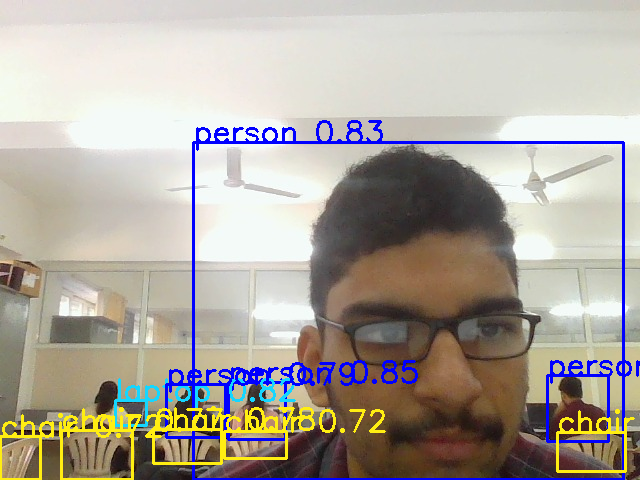


0: 480x640 4 persons, 5 chairs, 1 laptop, 13.2ms
Speed: 1.5ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


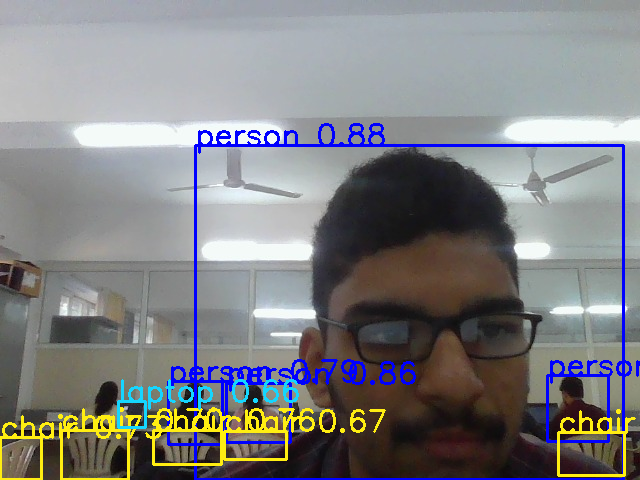


0: 480x640 3 persons, 2 chairs, 14.2ms
Speed: 4.5ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


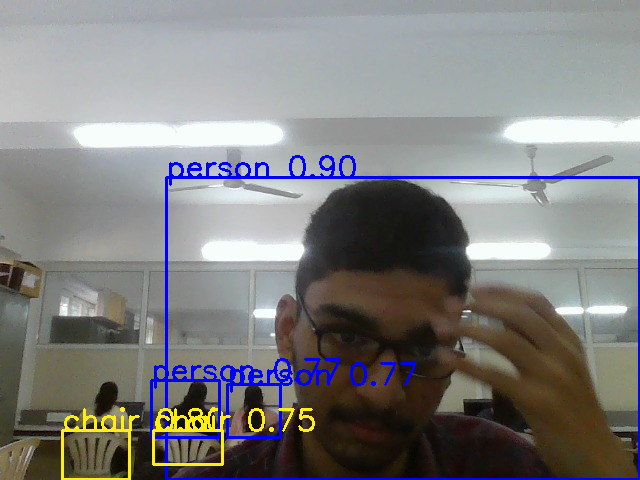


0: 480x640 5 persons, 5 chairs, 2 laptops, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


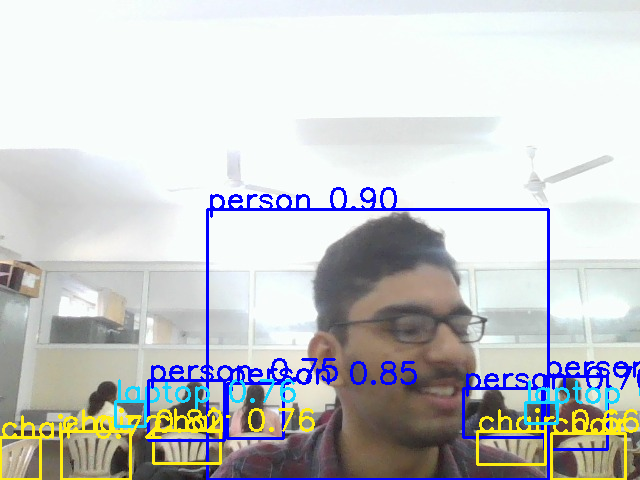


0: 480x640 5 persons, 5 chairs, 2 laptops, 13.2ms
Speed: 3.1ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


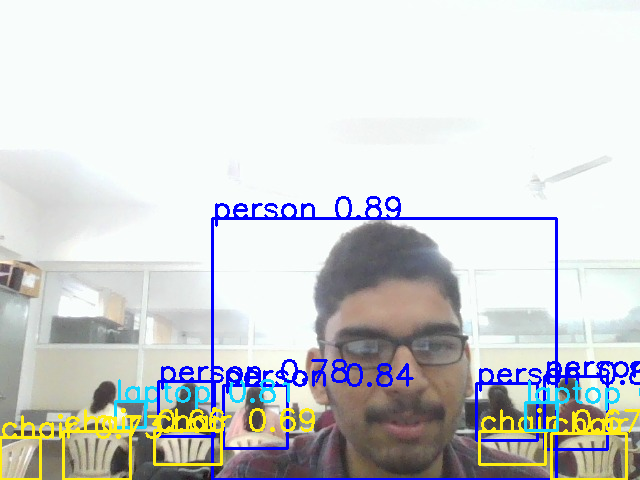


0: 480x640 6 persons, 5 chairs, 2 laptops, 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


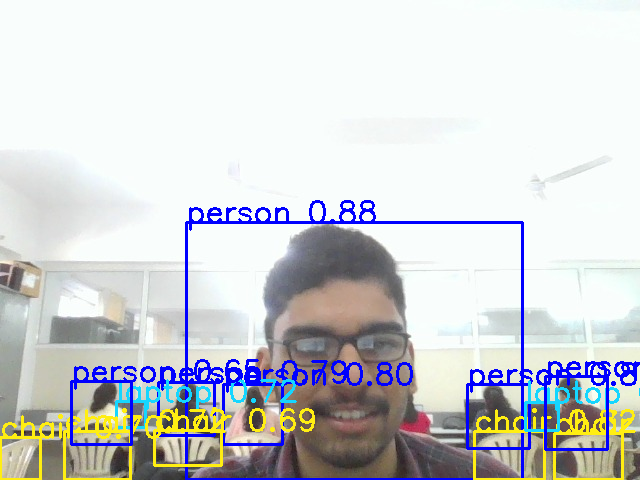

KeyboardInterrupt: 

In [ ]:
js_code = '''
function initCamera() {
    return new Promise((resolve, reject) => {
        const video = document.createElement('video');
        video.style.display = 'none';
        document.body.appendChild(video);
        const streamPromise = navigator.mediaDevices.getUserMedia({video: true});
        streamPromise.then((stream) => {
            video.srcObject = stream;
            video.onloadedmetadata = () => {
                resolve(video);
            };
            video.play();
        }).catch((error) => {
            reject(error);
        });
    });
}

async function takePhoto() {
    const video = await initCamera();
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const img = canvas.toDataURL('image/jpeg');
    return img;
}
'''

display(Javascript(js_code))

def js_to_image(js_reply):
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image_PIL = Image.open(io.BytesIO(image_bytes))
    image_np = np.array(image_PIL)
    frame = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return frame

yolo = YOLO('yolov8s.pt')

def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [base_colors[color_index][i] + increments[color_index][i] *
    (cls_num // len(base_colors)) % 256 for i in range(3)]
    return tuple(color)

while True:
    js_reply = eval_js('takePhoto()')
    frame = js_to_image(js_reply)

    if frame is None:
        continue

    results = yolo.track(frame, stream=True)

    for result in results:
        classes_names = result.names

        for box in result.boxes:
            if box.conf[0] > 0.4:
                [x1, y1, x2, y2] = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cls = int(box.cls[0])
                class_name = classes_names[cls]
                colour = getColours(cls)
                cv2.rectangle(frame, (x1, y1), (x2, y2), colour, 2)
                cv2.putText(frame, f'{classes_names[int(box.cls[0])]} {box.conf[0]:.2f}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 2)

    cv2_imshow(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

In [ ]:
!yolo predict model=yolov8s.pt source="/content/Cute_dog.jpg"

Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs

image 1/1 /content/Cute_dog.jpg: 448x640 1 dog, 70.1ms
Speed: 2.5ms preprocess, 70.1ms inference, 730.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
!yolo predict model=yolov8s.pt source="/content/portrait-dog-cat-looking-camera-600nw-1927231592.webp"

Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs

image 1/1 /content/portrait-dog-cat-looking-camera-600nw-1927231592.webp: 448x640 1 cat, 1 dog, 1 tie, 74.1ms
Speed: 4.5ms preprocess, 74.1ms inference, 562.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


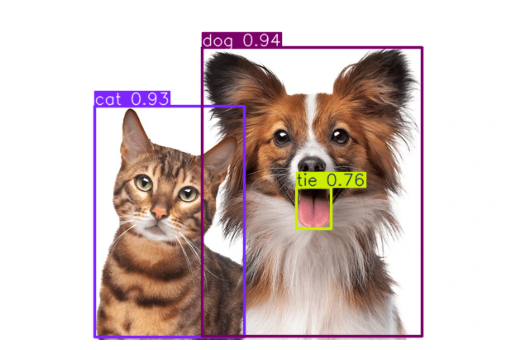

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/runs/detect/predict2/portrait-dog-cat-looking-camera-600nw-1927231592.webp')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
!yolo predict model=yolov8s.pt source="/content/road-woodland-mother-father-little-600nw-2378778007.webp"

Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs

image 1/1 /content/road-woodland-mother-father-little-600nw-2378778007.webp: 448x640 3 persons, 1 car, 1 truck, 1 cell phone, 71.7ms
Speed: 4.4ms preprocess, 71.7ms inference, 613.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


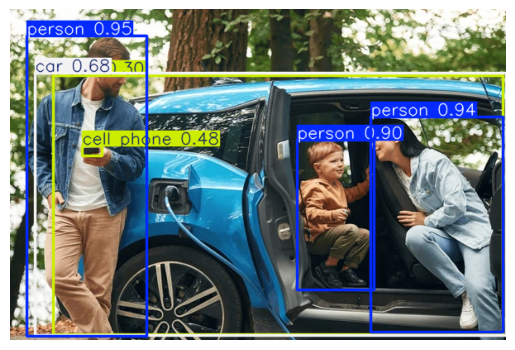

In [ ]:
img = mpimg.imread('/content/runs/detect/predict3/road-woodland-mother-father-little-600nw-2378778007.webp')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
!yolo predict model=yolov10n.pt source="/content/road-woodland-mother-father-little-600nw-2378778007.webp"

100% 5.59M/5.59M [00:00<00:00, 179MB/s]
Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,762,608 parameters, 0 gradients, 8.6 GFLOPs

image 1/1 /content/road-woodland-mother-father-little-600nw-2378778007.webp: 448x640 3 persons, 1 car, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 45.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


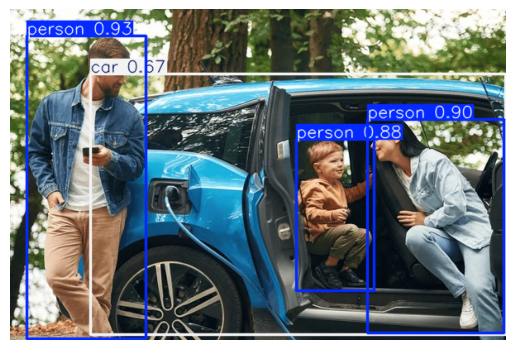

In [ ]:
img = mpimg.imread('/content/runs/detect/predict4/road-woodland-mother-father-little-600nw-2378778007.webp')
plt.imshow(img)
plt.axis('off')
plt.show()